Description for which files are where, what is needed

### What you need

This tutorial goes from parsing data to visualizing the posterior of MDSINE2.

The tables that you will need are:
* taxa counts
* qPCR table
* perturbations table
* taxonomy table
* metadata file

Our data is preprocessed in objects from a previous tutorial. For this tutorial we unpacking our data into it's composite tables to walk you through constructing your own `Study` objects


In [17]:
%matplotlib inline

import mdsine2 as md2
from mdsine2.names import STRNAMES
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path

In [18]:
output_dir = Path("../analysis/output/gibson-mini")
dataset_dir = output_dir / "datasets"

In [19]:
# Make example datasets from preprocessed data
def make_toy(dset):
    to_delete = []
    for taxon in dset.taxa:
        if taxon.idx >= 15:
            to_delete.append(taxon.name)
    dset.pop_taxa(to_delete)
    
    toy_dataset_path = dataset_dir / "{}-toy".format(dset.name)
    toy_dataset_path.mkdir(parents=True, exist_ok=True)
    
    dset.write_metadata_to_csv(path=toy_dataset_path / 'metadata.tsv')
    dset.write_qpcr_to_csv(path=toy_dataset_path / 'qpcr.tsv')
    if dset.perturbations is not None:
        dset.write_perturbations_to_csv(path=toy_dataset_path / 'perturbations.tsv')
    dset.write_reads_to_csv(path=toy_dataset_path / 'reads.tsv')
    dset.taxa.write_taxonomy_to_csv(path=toy_dataset_path / 'taxonomy.tsv')

In [20]:
healthy = md2.Study.load('../analysis/output/gibson/preprocessed/gibson_healthy_agg_taxa_filtered.pkl')
uc = md2.Study.load('../analysis/output/gibson/preprocessed/gibson_uc_agg_taxa_filtered.pkl')
replicates = md2.Study.load('../analysis/output/gibson/preprocessed/gibson_replicates_agg_taxa_filtered.pkl')

make_toy(dset=healthy)
make_toy(dset=uc)
make_toy(dset=replicates)

### Metadata table
The following table is a metadata table. It tells the `Study` object what subject and timepoint each sample belongs to

In [21]:
# Load metadata table
metadata = pd.read_csv(dataset_dir / 'healthy-toy' / 'metadata.tsv', sep='\t')
metadata.head()

,sampleID,subject,time
0,2-D10,2,10.0
1,2-D11,2,11.0
2,2-D14,2,14.0
3,2-D16,2,16.0
4,2-D18,2,18.0


### qPCR table
The following table is a qPCR table. This has the replicate measurements of the qPCR for every sample.

In [22]:
# qPCR table
qpcr = pd.read_csv(dataset_dir / 'healthy-toy' / 'qpcr.tsv', sep='\t')
qpcr.head()

,sampleID,measurement1,measurement2,measurement3
0,2-D10,4.129004e+10,6.423568e+10,8.384557e+10
1,2-D11,2.981363e+10,6.587538e+10,5.077812e+10
2,2-D14,1.647771e+10,7.104907e+10,2.498869e+10
3,2-D16,3.666487e+10,6.237899e+10,3.875999e+10
4,2-D18,4.523257e+10,2.320504e+10,2.330249e+10


### Perturbation table
The following table is a perturbation table. This tells the `Study` object which subject has a perturbation and when. There can be multiple perturbations for each subject. Note that this is only necessary if you have perturbations in your dataset.

In [23]:
perturbations = pd.read_csv(dataset_dir / 'healthy-toy' / 'perturbations.tsv', sep='\t')
display(perturbations)

,name,start,end,subject
0,High Fat Diet,21.5,28.5,2
1,High Fat Diet,21.5,28.5,3
2,High Fat Diet,21.5,28.5,4
3,High Fat Diet,21.5,28.5,5
4,Vancomycin,35.5,42.5,2
5,Vancomycin,35.5,42.5,3
6,Vancomycin,35.5,42.5,4
7,Vancomycin,35.5,42.5,5
8,Gentamicin,50.5,57.5,2
9,Gentamicin,50.5,57.5,3


### Reads table
The following table is a reads table. This shows the number of counts each taxa has for each sample ID.

In [24]:
reads = pd.read_csv(dataset_dir / 'healthy-toy' / 'reads.tsv', sep='\t')
reads.head()

,name,2-D10,2-D11,2-D14,2-D16,2-D18,2-D1AM,2-D1PM,2-D21AM,2-D21PM,...,5-D60AM,5-D60PM,5-D61,5-D62,5-D63,5-D64AM,5-D64PM,5-D7,5-D8,5-D9
0,OTU_1,1227,1793,8023,9503,3243,1830,199,3539,5270,...,218,409,2072,1160,723,1043,1732,4698,3310,4495
1,OTU_2,17362,6887,17165,29854,36759,2929,9880,15863,20619,...,3483,5742,10560,6931,7609,9301,10964,14754,6195,7539
2,OTU_3,8162,4911,9743,5776,11136,213,555,8566,12664,...,7,51,2039,2944,9708,1664,2578,8830,3163,6160
3,OTU_4,3793,2713,2683,3423,5351,9,32,3815,6512,...,8539,12437,15397,6717,4179,3597,5020,1395,895,2242
4,OTU_5,5852,3034,6870,6102,9957,2,7,4626,6412,...,1855,3481,5015,3096,2779,3302,1941,4893,2275,1903


### Taxonomy table
The following table is a taxonomy table. For each taxa name, it shows the sequence and taxonomy

In [15]:
taxonomy = pd.read_csv(dataset_dir / 'healthy-toy' / 'taxonomy.tsv', sep='\t')
display(taxonomy)

,name,sequence,kingdom,phylum,class,order,family,genus,species
0,OTU_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN
1,OTU_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/ovatus
2,OTU_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,muciniphila
3,OTU_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
4,OTU_5,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella,excrementihominis
5,OTU_6,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,dorei/fragilis
6,OTU_7,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,caccae
7,OTU_8,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,salyersiae
8,OTU_9,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
9,OTU_10,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,uniformis


With these 5 tables, you can run our model. You can parse them directly into a `Study` object with the `mdsine2.dataset.parse` command:

In [25]:
h_toy = md2.dataset.parse(name='healthy-toy-dataset', 
                         taxonomy=dataset_dir / 'healthy-toy' / 'taxonomy.tsv', 
                         reads=dataset_dir / 'healthy-toy' / 'reads.tsv', 
                         qpcr=dataset_dir / 'healthy-toy' / 'qpcr.tsv', 
                         perturbations=dataset_dir / 'healthy-toy' / 'perturbations.tsv', 
                         metadata=dataset_dir / 'healthy-toy' / 'metadata.tsv')
uc_toy = md2.dataset.parse(name='uc-toy-dataset', 
                         taxonomy=dataset_dir / 'uc-toy' / 'taxonomy.tsv', 
                         reads=dataset_dir / 'uc-toy' / 'reads.tsv', 
                         qpcr=dataset_dir / 'uc-toy' / 'qpcr.tsv', 
                         perturbations=dataset_dir / 'uc-toy' / 'perturbations.tsv', 
                         metadata=dataset_dir / 'uc-toy' / 'metadata.tsv')
rep_toy = md2.dataset.parse(name='replicates-toy-dataset', 
                         taxonomy=dataset_dir / 'replicates-toy' / 'taxonomy.tsv', 
                         reads=dataset_dir / 'replicates-toy' / 'reads.tsv', 
                         qpcr=dataset_dir / 'replicates-toy' / 'qpcr.tsv', 
                         metadata=dataset_dir / 'replicates-toy' / 'metadata.tsv')


2021-07-02 20:13:17,213 [INFO] [base.py (1284)] - TaxaSet parsng new taxonomy table. Resetting
2021-07-02 20:13:17,275 [INFO] [base.py (1284)] - TaxaSet parsng new taxonomy table. Resetting
2021-07-02 20:13:17,348 [INFO] [base.py (1284)] - TaxaSet parsng new taxonomy table. Resetting


You would just read these in with this parser. These are identical to our precomputed dataset 

# Learning the Negative Binomial dispersion parameters

This corresponds to the script ``

words here

In [37]:
params = md2.config.NegBinConfig(
    seed=0, burnin=100, n_samples=200,
    checkpoint=100, 
    basepath=str(output_dir / "negbin")
)

description

In [38]:
mcmc_negbin = md2.negbin.build_graph(
    params=params, 
    graph_name=rep_toy.name, 
    subjset=rep_toy
)

2021-07-02 20:16:06,980 [INFO] [inference.py (591)] - Setting Single Write, Multiple Read Mode
2021-07-02 20:16:06,982 [INFO] [inference.py (596)] - Setting the trace of learned parameters
2021-07-02 20:16:06,982 [INFO] [inference.py (597)] - #######################################
2021-07-02 20:16:06,983 [INFO] [inference.py (599)] - Setting the trace of Negative binomial dispersion a0
2021-07-02 20:16:06,987 [INFO] [inference.py (599)] - Setting the trace of Negative binomial dispersion a1
2021-07-02 20:16:06,992 [INFO] [inference.py (599)] - Setting the trace of Filtering
2021-07-02 20:16:07,003 [INFO] [inference.py (601)] - Setting the trace for diagnostic variables
2021-07-02 20:16:07,004 [INFO] [inference.py (602)] - ##########################################


description

In [39]:
mcmc_negbin = md2.negbin.run_graph(
    mcmc_negbin, 
    crash_if_error=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 330.62it/s]
2021-07-02 20:16:09,205 [INFO] [inference.py (510)] - Inference total time: 0.003054577112197876/Gibb step
2021-07-02 20:16:09,205 [INFO] [inference.py (514)] - remove local traces


description, we are repeating this on the smaller dataset so you know how to run it and know what it looks like. This is not representative of the real results because we only have the ten most abundant taxa here.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


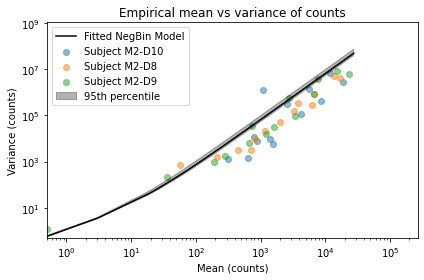

In [40]:
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc_negbin)
fig.tight_layout()

# Run the model

In [70]:
# Get a0 and a1 from negbin (get the mean of the posterior)
from mdsine2.names import STRNAMES
a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

print('negbin a0', a0)
print('negbin a1', a1)

basepath = output_dir / "mdsine2" / "uc0"
basepath.mkdir(exist_ok=True, parents=True)

# Initialize parameters of the model (Seed = 0)
params = md2.config.MDSINE2ModelConfig(
    basepath=str(basepath), 
    seed=0,
    burnin=50, 
    n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50
)

# The default number of modules is 30, which is larger than the number of taxa
# that we have in this dataset, which would throw a flag.
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

negbin a0 1.994035699234331e-10
negbin a1 0.06562195000302486


In [71]:
# initilize the graph
mcmc_uc0 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)


2021-07-02 20:30:25,789 [INFO] [base.py (2775)] - max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
2021-07-02 20:30:25,801 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
2021-07-02 20:30:25,819 [INFO] [run.py (254)] - There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
2021-07-02 20:30:25,822 [INFO] [run.py (289)] - Initializing Filtering
2021-07-02 20:30:25,823 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-07-02 20:30:25,824 [INFO] [posterior.py (2671)] - Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5
 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5
 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5
 61.  62.  63.  64. 

2021-07-02 20:30:26,103 [INFO] [run.py (329)] - Growth
2021-07-02 20:30:26,104 [INFO] [run.py (330)] - 	prior.loc: 1
2021-07-02 20:30:26,104 [INFO] [run.py (331)] - 	prior.scale2: 3158.713663801933
2021-07-02 20:30:26,105 [INFO] [run.py (332)] - 	value: [0.10964791 0.56202435 0.93984141 0.3618403  0.75880289 0.44916415
 0.30278078 0.72258538 0.64226612 0.34511696 0.23619727 0.72422836
 1.74801305 0.93771595 0.24703424]
2021-07-02 20:30:26,106 [INFO] [run.py (334)] - Self-Interactions
2021-07-02 20:30:26,106 [INFO] [run.py (335)] - 	prior.loc: 1.186848903491885
2021-07-02 20:30:26,107 [INFO] [run.py (336)] - 	prior.scale2: 14086.103197198898
2021-07-02 20:30:26,107 [INFO] [run.py (337)] - 	value: [7.20027987e-02 2.35208688e-01 2.62896147e-01 3.39807087e+00
 1.09772700e+00 6.76419192e-01 7.78850955e-01 1.18684890e+00
 1.30095169e+02 1.75951287e+02 9.11004716e-01 1.32674030e+02
 7.33154010e+00 3.53664657e+00 1.88587399e+00]
2021-07-02 20:30:26,108 [INFO] [run.py (339)] - Prior Variance Gr

2021-07-02 20:30:26,262 [INFO] [inference.py (602)] - ##########################################


In [72]:
mcmc_uc0 = md2.run_graph(mcmc_uc0, crash_if_error=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.89it/s]
2021-07-02 20:30:53,386 [INFO] [inference.py (510)] - Inference total time: 0.25743870973587035/Gibb step
2021-07-02 20:30:53,386 [INFO] [inference.py (514)] - remove local traces
2021-07-02 20:30:53,406 [INFO] [run.py (545)] - Denormalizing the parameters


2021-07-02 20:30:53,489 [INFO] [util.py (173)] - Number of clusters: 3
2021-07-02 20:30:53,490 [INFO] [util.py (179)] - Clusters assigned: [0 0 2 0 0 1 1 2 0 2 0 0 1 1 2]
Cluster 0
	 Bacteroidetes merdae OTU_18
Cluster 1
	 Bacteroidetes salyersiae OTU_8
	 Verrucomicrobia muciniphila OTU_3
	 Bacteroidetes uniformis OTU_10
Cluster 2
	 * Bacteroidetes OTU_1
	 Bacteroidetes fragilis/ovatus OTU_2
	 * Bacteroidetes OTU_4
	 Proteobacteria excrementihominis OTU_5
	 * Bacteroidetes OTU_9
	 Bacteroidetes distasonis OTU_12
	 Bacteroidetes goldsteinii OTU_13
Cluster 3
	 Firmicutes intestini OTU_17
	 * Firmicutes OTU_16
	 Bacteroidetes dorei/fragilis OTU_6
	 Bacteroidetes caccae OTU_7


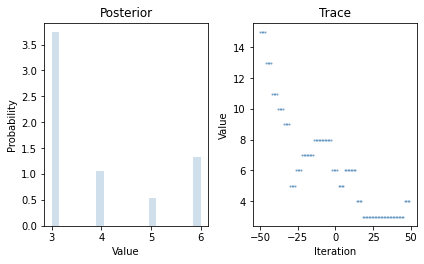

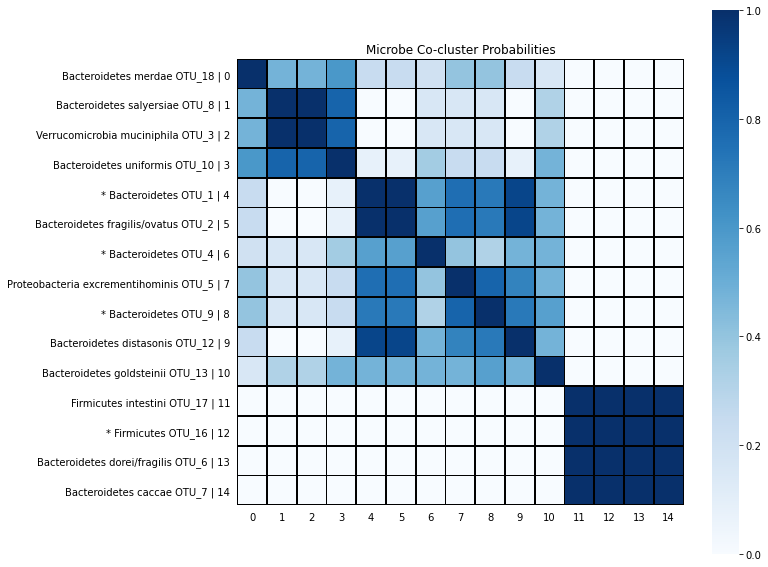

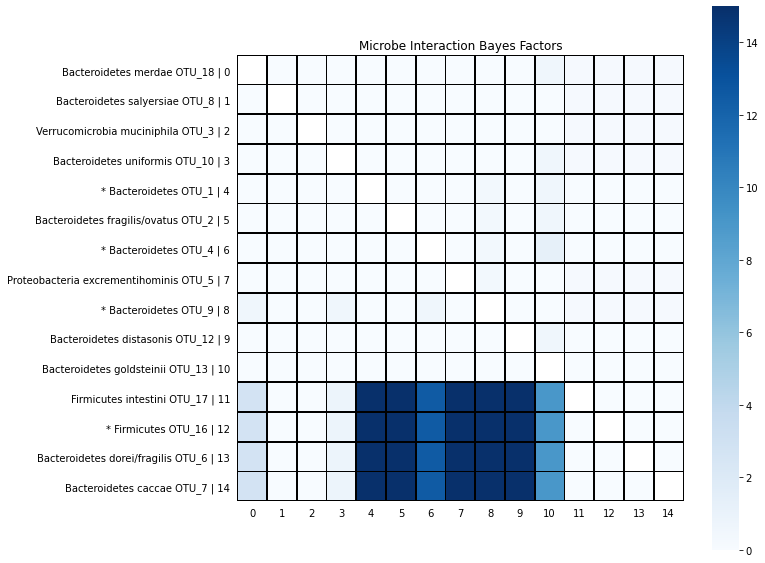

In [73]:
clustering = mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxa = mcmc_uc0.graph.data.taxa

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxa[oidx], taxa))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_probabilities(coclusters, taxa=uc_toy.taxa,
    yticklabels='%(paperformat)s | %(index)s', order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc0)
md2.visualization.render_bayes_factors(
    bayes_factors, taxa=taxa, yticklabels='%(paperformat)s | %(index)s',
    order=order)
plt.show()

# Calculating  $\hat{r}$

In [74]:
uc1_basepath = output_dir / 'mdsine2' / 'uc1'
uc1_basepath.mkdir(exist_ok=True)

params = md2.config.MDSINE2ModelConfig(
    basepath=uc1_basepath, 
    seed=1, 
    burnin=50, 
    n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc_uc1 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc_uc1 = md2.run_graph(mcmc_uc1, crash_if_error=True)


2021-07-02 20:31:56,678 [INFO] [base.py (2775)] - max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
2021-07-02 20:31:56,690 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
2021-07-02 20:31:56,708 [INFO] [run.py (254)] - There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
2021-07-02 20:31:56,712 [INFO] [run.py (289)] - Initializing Filtering
2021-07-02 20:31:56,712 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-07-02 20:31:56,713 [INFO] [posterior.py (2671)] - Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5
 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5
 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5
 61.  62.  63.  64. 

2021-07-02 20:31:56,996 [INFO] [run.py (329)] - Growth
2021-07-02 20:31:56,996 [INFO] [run.py (330)] - 	prior.loc: 1
2021-07-02 20:31:56,997 [INFO] [run.py (331)] - 	prior.scale2: 2863.029720671062
2021-07-02 20:31:56,997 [INFO] [run.py (332)] - 	value: [0.10937296 0.53507287 0.87455003 0.38035116 0.79304176 0.50134921
 0.31941868 0.79066979 0.57353259 0.49120609 0.23663541 0.66907265
 1.78585994 0.94713669 0.26608305]
2021-07-02 20:31:56,997 [INFO] [run.py (334)] - Self-Interactions
2021-07-02 20:31:56,998 [INFO] [run.py (335)] - 	prior.loc: 1.2962054387337747
2021-07-02 20:31:56,998 [INFO] [run.py (336)] - 	prior.scale2: 16801.485394030202
2021-07-02 20:31:56,999 [INFO] [run.py (337)] - 	value: [7.19763225e-02 2.24413609e-01 2.47063151e-01 3.43886807e+00
 1.13911335e+00 7.20603191e-01 8.19433851e-01 1.29620544e+00
 1.20519455e+02 2.26534237e+02 9.11610446e-01 1.27672940e+02
 7.48751601e+00 3.54982202e+00 2.00285159e+00]
2021-07-02 20:31:56,999 [INFO] [run.py (339)] - Prior Variance G

2021-07-02 20:31:57,161 [INFO] [inference.py (602)] - ##########################################
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]
2021-07-02 20:32:23,726 [INFO] [inference.py (510)] - Inference total time: 0.2656212067604065/Gibb step
2021-07-02 20:32:23,727 [INFO] [inference.py (514)] - remove local traces
2021-07-02 20:32:23,747 [INFO] [run.py (545)] - Denormalizing the parameters


2021-07-02 20:32:23,822 [INFO] [util.py (173)] - Number of clusters: 4
2021-07-02 20:32:23,822 [INFO] [util.py (179)] - Clusters assigned: [2 3 0 0 2 1 0 0 2 0 2 2 1 1 0]
Cluster 0
	 Bacteroidetes fragilis/ovatus OTU_2
Cluster 1
	 Verrucomicrobia muciniphila OTU_3
	 * Bacteroidetes OTU_4
	 Bacteroidetes caccae OTU_7
	 Bacteroidetes salyersiae OTU_8
	 Bacteroidetes uniformis OTU_10
	 Bacteroidetes merdae OTU_18
Cluster 2
	 Firmicutes intestini OTU_17
	 * Firmicutes OTU_16
	 Bacteroidetes dorei/fragilis OTU_6
Cluster 3
	 * Bacteroidetes OTU_1
	 Proteobacteria excrementihominis OTU_5
	 * Bacteroidetes OTU_9
	 Bacteroidetes distasonis OTU_12
	 Bacteroidetes goldsteinii OTU_13


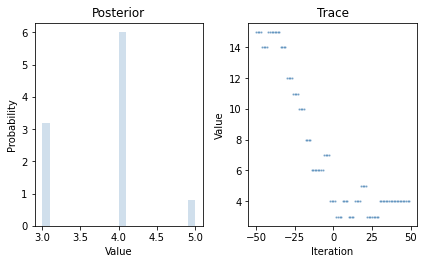

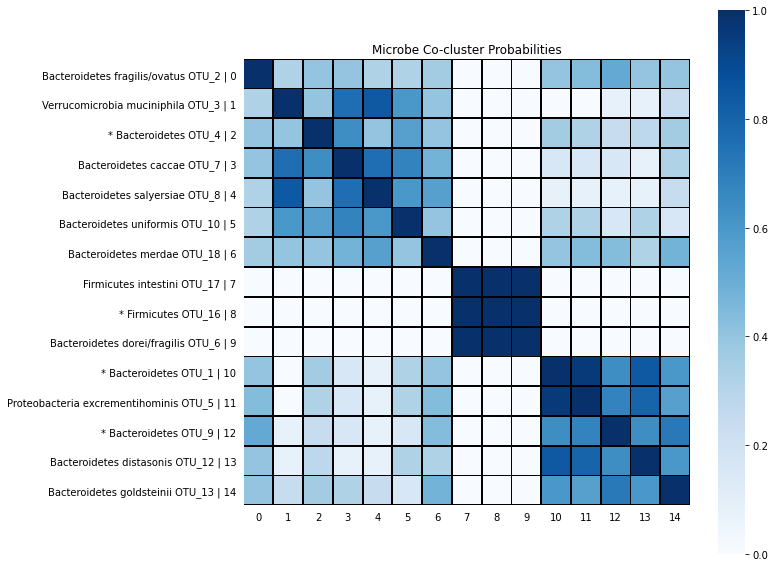

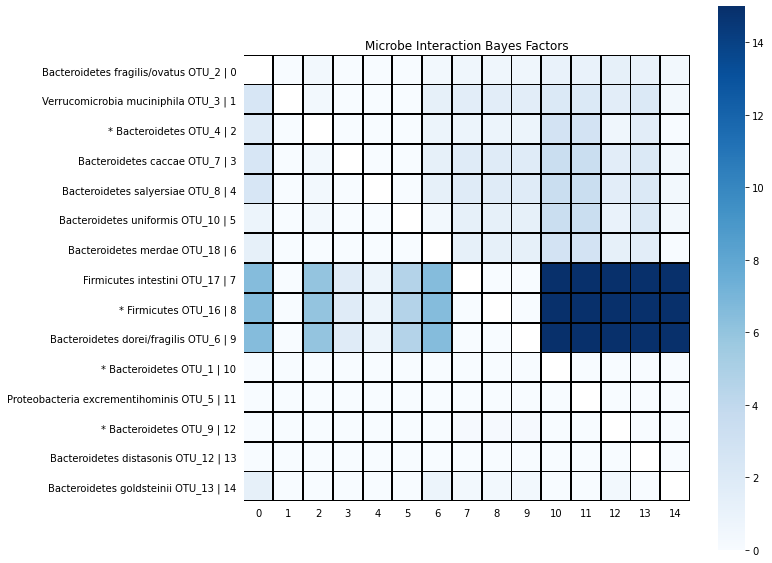

In [75]:
clustering = mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxa = mcmc_uc1.graph.data.taxa

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxa[oidx], taxa))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_probabilities(
    coclusters, taxa=uc_toy.taxa, yticklabels='%(paperformat)s | %(index)s',
    order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc1)
md2.visualization.render_bayes_factors(
    bayes_factors, taxa=taxa, yticklabels='%(paperformat)s | %(index)s',
    order=order)

plt.show()

In [76]:
chains = [mcmc_uc0, mcmc_uc1]
start = 10
end = 20
vname = STRNAMES.GROWTH_VALUE

rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Growth parameter r-hat:', rhat)

vname = STRNAMES.CONCENTRATION
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Concentration parameter r-hat:', rhat)

vname = STRNAMES.PROCESSVAR
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Process variance parameter r-hat:', rhat)


Growth parameter r-hat: [1.9125264  1.88422881 1.64888987 1.66215231 2.19419599 1.94706353
 1.65061479 1.67021029 1.96279408 1.82476964 1.90273436 1.70847859
 3.57066284 2.41936887 1.72306361]
Concentration parameter r-hat: [5.50597982]
Process variance parameter r-hat: [5.55641786]


# Consensus clustering
Run the model with a fixed modules

In [77]:
basepath = output_dir / 'mdsine2-fixed-cluster'
basepath.mkdir(exist_ok=True)

# Use the clustering from a previous as the clustering assignment
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# Do not learn the clustering parameters
params.LEARN[STRNAMES.CLUSTERING] = False
params.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = str(uc1_basepath / "mcmc.pkl")

mcmc = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

2021-07-02 20:32:24,398 [INFO] [base.py (2775)] - max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
2021-07-02 20:32:24,410 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
2021-07-02 20:32:24,427 [INFO] [run.py (254)] - There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
2021-07-02 20:32:24,430 [INFO] [run.py (289)] - Initializing Filtering
2021-07-02 20:32:24,431 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-07-02 20:32:24,432 [INFO] [posterior.py (2671)] - Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5
 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5
 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5
 61.  62.  63.  64. 

2021-07-02 20:32:24,752 [INFO] [run.py (329)] - Growth
2021-07-02 20:32:24,753 [INFO] [run.py (330)] - 	prior.loc: 1
2021-07-02 20:32:24,753 [INFO] [run.py (331)] - 	prior.scale2: 3158.713663801933
2021-07-02 20:32:24,754 [INFO] [run.py (332)] - 	value: [0.10964791 0.56202435 0.93984141 0.3618403  0.75880289 0.44916415
 0.30278078 0.72258538 0.64226612 0.34511696 0.23619727 0.72422836
 1.74801305 0.93771595 0.24703424]
2021-07-02 20:32:24,754 [INFO] [run.py (334)] - Self-Interactions
2021-07-02 20:32:24,754 [INFO] [run.py (335)] - 	prior.loc: 1.186848903491885
2021-07-02 20:32:24,755 [INFO] [run.py (336)] - 	prior.scale2: 14086.103197198898
2021-07-02 20:32:24,755 [INFO] [run.py (337)] - 	value: [7.20027987e-02 2.35208688e-01 2.62896147e-01 3.39807087e+00
 1.09772700e+00 6.76419192e-01 7.78850955e-01 1.18684890e+00
 1.30095169e+02 1.75951287e+02 9.11004716e-01 1.32674030e+02
 7.33154010e+00 3.53664657e+00 1.88587399e+00]
2021-07-02 20:32:24,756 [INFO] [run.py (339)] - Prior Variance Gr

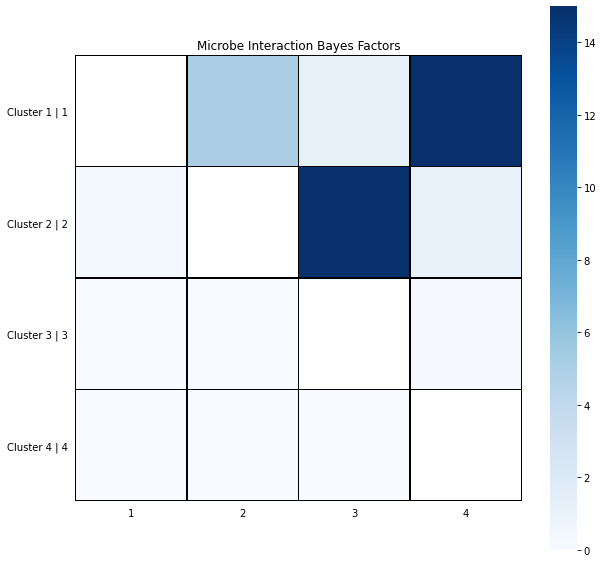

In [78]:
# Plot the posterior
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
bf_taxa = md2.generate_interation_bayes_factors_posthoc(mcmc)
bf_clustering = md2.condense_fixed_clustering_interaction_matrix(bf_taxa, clustering=clustering)

labels = ['Cluster {} | {}'.format(i+1, i+1) for i in range(len(clustering))]
md2.visualization.render_bayes_factors(bf_clustering, yticklabels=labels)
plt.show()

# Cross validation

Take out a single subject and use that as initial conditions for forward simulation

In [79]:
# Make the data and validation Study objects
holdout_study = md2.dataset.parse(
    name='uc-toy-dataset', 
    taxonomy=dataset_dir / 'uc-toy' / 'taxonomy.tsv', 
    reads=dataset_dir / 'uc-toy' / 'reads.tsv', 
    qpcr=dataset_dir / 'uc-toy' / 'qpcr.tsv', 
    perturbations=dataset_dir / 'uc-toy' / 'perturbations.tsv', 
    metadata=dataset_dir / 'uc-toy' / 'metadata.tsv'
)

val = holdout_study.pop_subject('8')
val.name += '-validate'

print(holdout_study.name)
for subj in holdout_study:
    print(subj.name)
for pert in holdout_study.perturbations:
    print(pert)
print()
print(val.name)
for subj in val:
    print(subj.name)
for pert in val.perturbations:
    print(pert)


2021-07-02 20:32:46,056 [INFO] [base.py (1284)] - TaxaSet parsng new taxonomy table. Resetting
uc-toy-dataset
10
6
7
9
Perturbation High Fat Diet:
	Subject 6: (21.5, 28.5)
	Subject 7: (21.5, 28.5)
	Subject 9: (21.5, 28.5)
	Subject 10: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 6: (35.5, 42.5)
	Subject 7: (35.5, 42.5)
	Subject 9: (35.5, 42.5)
	Subject 10: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 6: (50.5, 57.5)
	Subject 7: (50.5, 57.5)
	Subject 9: (50.5, 57.5)
	Subject 10: (50.5, 57.5)


unnamed-study-validate
8
Perturbation High Fat Diet:
	Subject 8: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 8: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 8: (50.5, 57.5)



In [80]:
cv_output_dir = output_dir / "cv"

# Learn the model
params = md2.config.MDSINE2ModelConfig(
    basepath=cv_output_dir / study.name, 
    seed=0, 
    burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50
)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc = md2.initialize_graph(params=params, graph_name=holdout_study.name, subjset=holdout_study)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

2021-07-02 20:32:46,146 [INFO] [base.py (2775)] - max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
2021-07-02 20:32:46,156 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
2021-07-02 20:32:46,170 [INFO] [run.py (254)] - There are 297 qPCR measurements for 3 buckets. Each bucket is 99 measurements long
2021-07-02 20:32:46,173 [INFO] [run.py (289)] - Initializing Filtering
2021-07-02 20:32:46,174 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-07-02 20:32:46,175 [INFO] [posterior.py (2671)] - Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5
 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5
 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5
 61.  62.  63.  64.  

2021-07-02 20:32:46,409 [INFO] [run.py (329)] - Growth
2021-07-02 20:32:46,409 [INFO] [run.py (330)] - 	prior.loc: 1
2021-07-02 20:32:46,410 [INFO] [run.py (331)] - 	prior.scale2: 2945.846680977727
2021-07-02 20:32:46,410 [INFO] [run.py (332)] - 	value: [0.14858644 0.54275655 0.87651013 0.42091904 0.671922   0.4360456
 0.30698851 0.61620612 0.56042433 0.43937997 0.220384   0.76539027
 1.82417245 1.05264282 0.33033393]
2021-07-02 20:32:46,411 [INFO] [run.py (334)] - Self-Interactions
2021-07-02 20:32:46,411 [INFO] [run.py (335)] - 	prior.loc: 0.9574570433943593
2021-07-02 20:32:46,411 [INFO] [run.py (336)] - 	prior.scale2: 9167.239899454653
2021-07-02 20:32:46,412 [INFO] [run.py (337)] - 	value: [8.22976511e-02 2.18111646e-01 2.41398615e-01 3.56181829e+00
 9.22279460e-01 6.48683983e-01 7.62494038e-01 9.57457043e-01
 1.11335902e+02 1.98778018e+02 8.44271670e-01 1.31432028e+02
 7.23969532e+00 3.64444843e+00 2.33994196e+00]
2021-07-02 20:32:46,413 [INFO] [run.py (339)] - Prior Variance Gro

2021-07-02 20:32:46,552 [INFO] [inference.py (602)] - ##########################################
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.83it/s]
2021-07-02 20:33:07,277 [INFO] [inference.py (510)] - Inference total time: 0.20723867416381836/Gibb step
2021-07-02 20:33:07,277 [INFO] [inference.py (514)] - remove local traces
2021-07-02 20:33:07,294 [INFO] [run.py (545)] - Denormalizing the parameters


In [81]:
# Forward simulate

# Get the initial conditions
subj = val['8']
M_truth = subj.matrix()['abs']
initial_conditions = M_truth[:,0]
initial_conditions[initial_conditions==0] = 1e5
times = subj.times

# Forward simulate for each gibb step
M = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(
    mcmc, subj=subj, 
    initial_conditions=initial_conditions, 
    times=times, 
    simulation_dt=0.01
)


2021-07-02 20:33:07,607 [INFO] [model.py (215)] - 5/50 - 0.2650003433227539
2021-07-02 20:33:07,872 [INFO] [model.py (215)] - 10/50 - 0.26399874687194824
2021-07-02 20:33:08,135 [INFO] [model.py (215)] - 15/50 - 0.2620112895965576
2021-07-02 20:33:08,396 [INFO] [model.py (215)] - 20/50 - 0.2610001564025879
2021-07-02 20:33:08,659 [INFO] [model.py (215)] - 25/50 - 0.26203060150146484
2021-07-02 20:33:08,920 [INFO] [model.py (215)] - 30/50 - 0.2609994411468506
2021-07-02 20:33:09,184 [INFO] [model.py (215)] - 35/50 - 0.2630002498626709
2021-07-02 20:33:09,449 [INFO] [model.py (215)] - 40/50 - 0.26400017738342285
2021-07-02 20:33:09,711 [INFO] [model.py (215)] - 45/50 - 0.2620692253112793


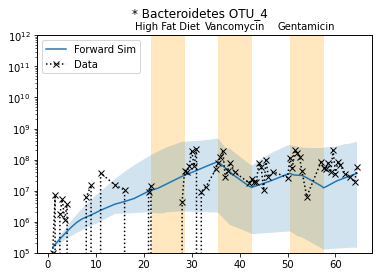

In [82]:
# Plot the forward sims, 25th-75th percentile
taxa = subj.taxa

low = np.percentile(M, q=25, axis=0)
high = np.percentile(M, q=75, axis=0)
med = np.percentile(M, q=50, axis=0)

oidx = 3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(times, y1=low[oidx, :], y2=high[oidx, :], alpha=0.2)
ax.plot(times, med[oidx,:], label='Forward Sim')
ax.plot(times, M_truth[oidx, :], label='Data', marker='x', color='black',
       linestyle=':')
ax.set_yscale('log')

md2.visualization.shade_in_perturbations(ax, perturbations=subj.perturbations, subj=subj)
ax.set_ylim(bottom=1e5, top=1e12)

ax.legend()

fig.suptitle(md2.taxaname_for_paper(taxa[oidx], taxa))
plt.show()

# Keystoneness
Calculate the keystoneness by using the `MDSINE2_Paper/keystoneness.py` script of the chain `uc100`.

Each line out table indicates which OTUs to leave out for that iteration of forward simulating to the steady state. Note that these are 0-based indecies for the OTUs.

In [83]:
# # Make the leave out table - leave out each Cluster
# ky_output_dir = output_dir / "keystoneness"

# mcmc = md2.BaseMCMC.load(uc1_basepath / 'mcmc.pkl')
# clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
# md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
# print(clustering)

# txt = '\n'.join([','.join([str(oidx) for oidx in cluster.members]) for cluster in clustering])
# f = open(ky_output_dir / 'leave_out_table.csv', 'w')
# f.write(txt)
# f.close()
# print(txt)

# !python ../analysis/helpers/keystoneness.py \
#     --input output/mdsine2/uc0/mcmc.pkl \
#     --study output/mdsine2/uc0/subjset.pkl \
#     --leave-out-table output/keystoneness/leave_out_table.csv \
#     --sep , \
#     --simulation-dt 0.01 \
#     --output-basepath output/keystoneness/ \
#     --n-days 60

In [84]:
# # Display the steady state table
# df_steady_state = pd.read_csv('output/keystoneness/uc-toy-dataset/steady-state-table.tsv',
#                 sep='\t', index_col=0)
# df_steady_state.head()

In [85]:
# # Display the keystoneness table
# df_keystoneness = pd.read_csv('output/keystoneness/uc-toy-dataset/keystoneness.tsv',
#                 sep='\t', index_col=0)
# df_keystoneness.head()

# Perturbation analysis

In [86]:
# !python ../perturbation_analysis.py \
#     --input output/mdsine2/uc0/mcmc.pkl \
#     --study output/mdsine2/uc0/subjset.pkl \
#     --leave-out-table output/keystoneness/leave_out_table.csv \
#     --perturbation Vancomycin \
#     --output-basepath output/keystoneness/pert_analysis \
#     --start-perturbation 60 \
#     --end-perturbation 120 \
#     --n-days 180

# Full Synthetic
Forward simulate with ICML dataset

2021-07-02 20:34:19,797 [INFO] [synthetic.py (175)] - Forward simulating subj1
2021-07-02 20:34:19,825 [INFO] [synthetic.py (175)] - Forward simulating subj2
2021-07-02 20:34:19,853 [INFO] [synthetic.py (175)] - Forward simulating subj3
2021-07-02 20:34:19,882 [INFO] [synthetic.py (175)] - Forward simulating subj4
2021-07-02 20:34:19,912 [INFO] [synthetic.py (175)] - Forward simulating subj5
2021-07-02 20:34:19,955 [INFO] [synthetic.py (249)] - Fitting real data
13
5


<AxesSubplot:title={'center':'Abundance, Subject subj1, asv level'}, xlabel='Days', ylabel='CFUs/g'>

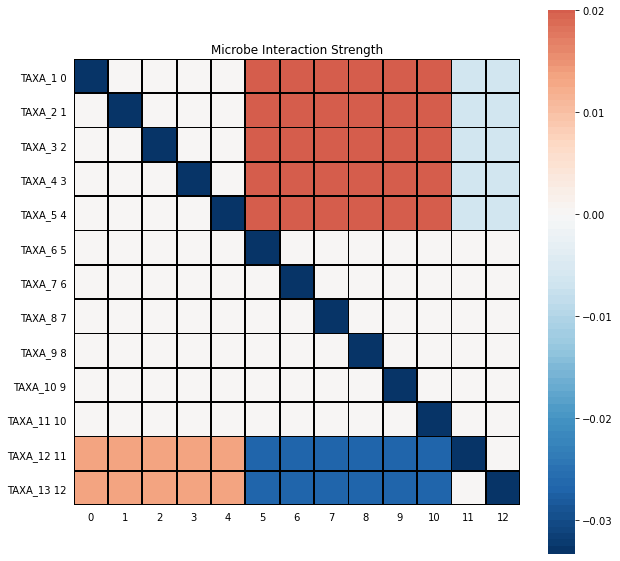

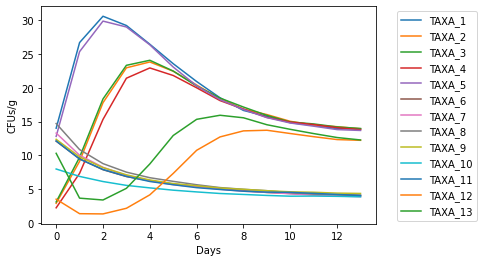

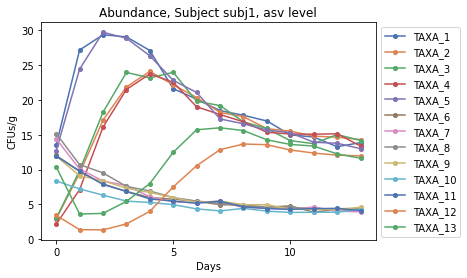

In [88]:
# Make the dynamics
syn = md2.Synthetic(name='icml', seed=0)
syn.icml_dynamics(n_taxa=13)

md2.visualization.render_interaction_strength(
    syn.model.interactions, 
    log_scale=False, 
    taxa=syn.taxa,
    center_colors=True
)

# Set the number of subjects
syn.set_subjects(['subj{}'.format(i+1) for i in range(5)])
syn.subjs

# Set the timepoints
syn.set_timepoints(times=np.arange(14))
syn.times

# Forward simulate
pv = md2.model.MultiplicativeGlobal(0.01**2) # 5% process variation
syn.generate_trajectories(dt=0.01, init_dist=md2.variables.Uniform(low=2, high=15),
                          processvar=pv)

# Plot the data without measurement noise
fig = plt.figure()
ax = fig.add_subplot(111)
for taxon in range(13):
    ax.plot(syn.times, syn._data['subj1'][taxon, :], label=syn.taxa[taxon].name)
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_ylabel('CFUs/g')
ax.set_xlabel('Days')

# Make a study object and simulate measurement noise
study = syn.simulateMeasurementNoise(
    a0=1e-10, a1=0.001, qpcr_noise_scale=0.01, approx_read_depth=60000, 
    name='sim-study')

print(len(study.taxa))
print(len(study))
      

# Visualize with noise
md2.visualization.abundance_over_time(study['subj1'], dtype='abs', yscale_log=False)

In [90]:
# Inference with the ICML dataset
params = md2.config.MDSINE2ModelConfig(
    basepath="../analysis/output/icml/mdsine2",
    seed=6, 
    burnin=200, 
    n_samples=600, 
    checkpoint=100, 
    negbin_a0=1e-10, negbin_a1=0.001
)

params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc = md2.initialize_graph(params=params, graph_name='icml-graph', subjset=study)

clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
print(clustering.coclusters.value.shape)
print(len(clustering))

mcmc = md2.run_graph(mcmc, crash_if_error=True)


2021-07-02 20:36:15,208 [INFO] [base.py (2775)] - max_value found: 174.74130607742032, scaling_factor: 0.5722745368269957
2021-07-02 20:36:15,210 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.7227E-01
2021-07-02 20:36:15,215 [INFO] [run.py (254)] - There are 70 qPCR measurements for 3 buckets. Each bucket is 23 measurements long
2021-07-02 20:36:15,216 [INFO] [run.py (289)] - Initializing Filtering
2021-07-02 20:36:15,216 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-07-02 20:36:15,217 [INFO] [posterior.py (2671)] - Essential timepoints: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
2021-07-02 20:36:15,257 [INFO] [run.py (289)] - Initializing Zero inflation
2021-07-02 20:36:15,258 [INFO] [design_matrices.py (851)] - Initializing LHS vector
2021-07-02 20:36:15,259 [INFO] [design_matrices.py (1006)] - Initializing growth design matrix
2021-07-02 20:36:15,259 [INFO] [design_matrices.py (932)] - Initializing self-int

2021-07-02 20:36:15,289 [INFO] [run.py (346)] - 	prior.scale: 3.249074469976051
2021-07-02 20:36:15,289 [INFO] [run.py (347)] - 	value: 16.245372349880256
2021-07-02 20:36:15,289 [INFO] [run.py (349)] - Prior Variance Interactions
2021-07-02 20:36:15,292 [INFO] [run.py (350)] - 	prior.dof: 2.01
2021-07-02 20:36:15,292 [INFO] [run.py (351)] - 	prior.scale: 0.0808227480093528
2021-07-02 20:36:15,292 [INFO] [run.py (352)] - 	value: 16.245372349880256
2021-07-02 20:36:15,293 [INFO] [run.py (354)] - Process Variance
2021-07-02 20:36:15,293 [INFO] [run.py (355)] - 	prior.dof: 2.5
2021-07-02 20:36:15,293 [INFO] [run.py (356)] - 	prior.scale: 0.008000000000000002
2021-07-02 20:36:15,294 [INFO] [run.py (357)] - 	prior mean: 0.04000000000000001
2021-07-02 20:36:15,294 [INFO] [run.py (359)] - Concentration
2021-07-02 20:36:15,294 [INFO] [run.py (360)] - 	prior.shape: 1e-05
2021-07-02 20:36:15,295 [INFO] [run.py (361)] - 	prior.scale: 100000.0
2021-07-02 20:36:15,295 [INFO] [run.py (362)] - 	value

<AxesSubplot:title={'center':'Microbe Interaction Bayes Factors'}>

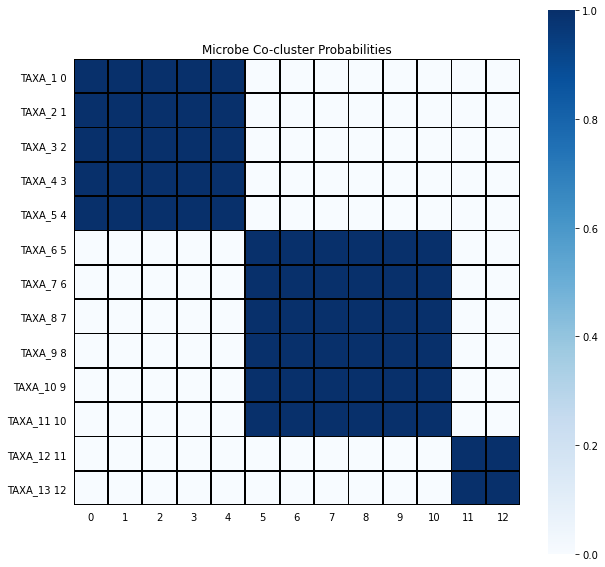

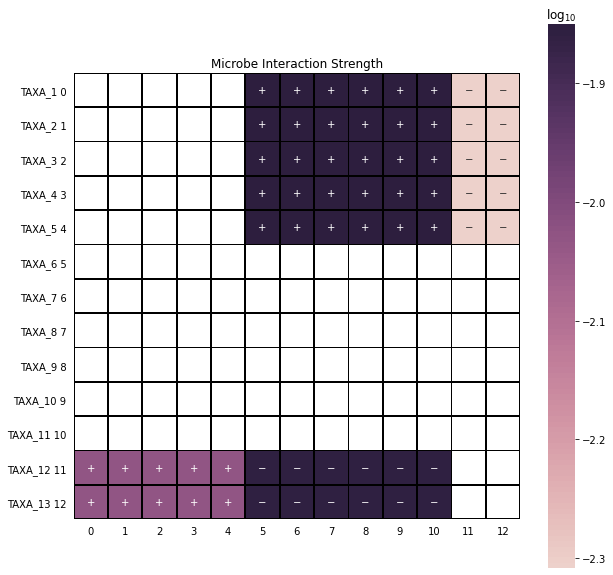

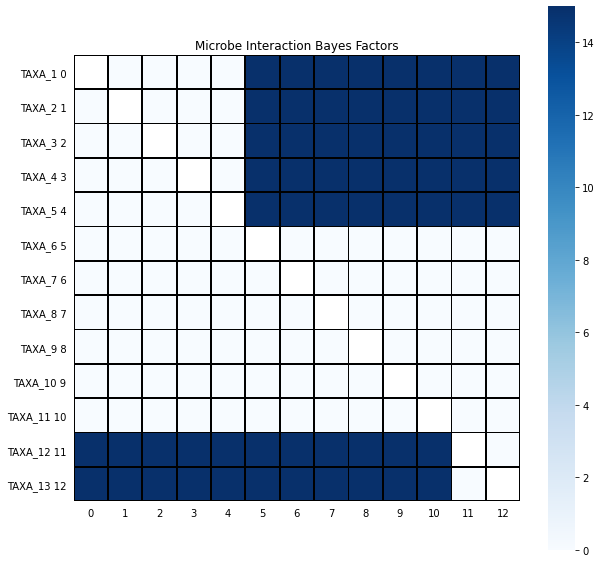

In [91]:
# Plot the posterior
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
coclusters = md2.summary(clustering.coclusters)['mean']
md2.visualization.render_cocluster_probabilities(coclusters, taxa=study.taxa)

interactions = mcmc.graph[STRNAMES.INTERACTIONS_OBJ]
A = md2.summary(interactions, set_nan_to_0=True)['mean']
md2.visualization.render_interaction_strength(A, log_scale=True, taxa=study.taxa, 
                                              center_colors=True)
bf = md2.generate_interation_bayes_factors_posthoc(mcmc)
md2.visualization.render_bayes_factors(bf, taxa=study.taxa)


### Compute the errors between the predicted and the ground truth

Calculate the following statistics:
1. AUCROC of interactions
2. RMSE of interactions
3. RMSE growth values
4. relRMSE of predicted trajectory
5. Normalized mutual information of cluster assignments

In [92]:
# AUCROC
# ------

# Get truth
truth = syn.model.interactions

# Get predicted, set self-interactions as diagonal
pred = mcmc.graph[STRNAMES.INTERACTIONS_OBJ].get_trace_from_disk()
si = mcmc.graph[STRNAMES.SELF_INTERACTION_VALUE].get_trace_from_disk()
for i in range(len(study.taxa)):
    pred[:,i,i] = si[:, i]

roc_per_gibb = md2.metrics.rocauc_posterior_interactions(
    pred=pred, truth=truth, signed=True, per_gibb=True)
print('Average ROCAUC:', np.mean(roc_per_gibb))



Average ROCAUC: 0.9496124031007754


In [93]:
# RMSE of interactions
# --------------------
arr = np.zeros(pred.shape[0])
for gibb in range(len(arr)):
    arr[gibb] = md2.metrics.RMSE(truth, pred[gibb])
print('Average RMSE error of interactions:', np.mean(arr))

Average RMSE error of interactions: 0.027262158502517765


In [94]:
# RMSE of growth values
# ---------------------

truth = syn.model.growth
pred = mcmc.graph[STRNAMES.GROWTH_VALUE].get_trace_from_disk()

arr = np.zeros(pred.shape[0])
for gibb in range(len(arr)):
    arr[gibb] = md2.metrics.RMSE(truth, pred[gibb])
print('Average RMSE error of growth values', np.mean(arr))

Average RMSE error of growth values 0.04169501601498125


2021-07-02 20:36:52,189 [INFO] [synthetic.py (175)] - Forward simulating subj-validate
2021-07-02 20:36:52,266 [INFO] [model.py (215)] - 5/400 - 0.04500699043273926
2021-07-02 20:36:52,313 [INFO] [model.py (215)] - 10/400 - 0.04599928855895996
2021-07-02 20:36:52,361 [INFO] [model.py (215)] - 15/400 - 0.04800057411193848
2021-07-02 20:36:52,408 [INFO] [model.py (215)] - 20/400 - 0.04700016975402832
2021-07-02 20:36:52,455 [INFO] [model.py (215)] - 25/400 - 0.04595327377319336
2021-07-02 20:36:52,503 [INFO] [model.py (215)] - 30/400 - 0.048000335693359375
2021-07-02 20:36:52,549 [INFO] [model.py (215)] - 35/400 - 0.04599952697753906
2021-07-02 20:36:52,596 [INFO] [model.py (215)] - 40/400 - 0.045998334884643555
2021-07-02 20:36:52,643 [INFO] [model.py (215)] - 45/400 - 0.04599905014038086
2021-07-02 20:36:52,689 [INFO] [model.py (215)] - 50/400 - 0.046000003814697266
2021-07-02 20:36:52,735 [INFO] [model.py (215)] - 55/400 - 0.045999765396118164
2021-07-02 20:36:52,781 [INFO] [model.py 

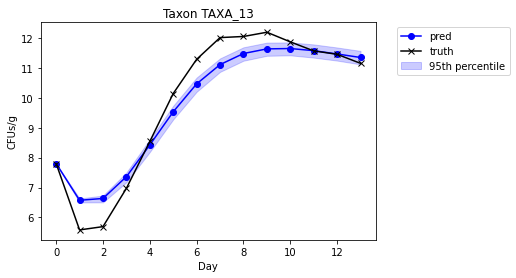

In [95]:
# relRMSE of predicted trajectories
# ---------------------------------

# Simulate a new trajectory
syn.add_subject('subj-validate')

syn.generate_trajectories(
    dt=0.01, init_dist=md2.variables.Uniform(low=2, high=15), 
    processvar=pv, seed=1010101) # only generates a new trajectory for the new subject

# Get the ground truth
truth = syn._data['subj-validate']

# Get the initial conditions
# has the shape [n_taxa, n_times]
initial_conditions = truth[:, 0]

# forward simulate
pred = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(
    mcmc=mcmc, subj=None, initial_conditions=initial_conditions,
    times=syn.times, simulation_dt=0.01)
pred.shape

# Plot the predicted trajectory for the last taxa
low = np.percentile(pred[:, -1, :], q=2.5, axis=0)
high = np.percentile(pred[:, -1, :], q=97.5, axis=0)
med = np.percentile(pred[:, -1, :], q=50, axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(syn.times, low, high, alpha=0.2, color='blue',
                label='95th percentile')
ax.plot(syn.times, med, color='blue', label='pred', marker='o')
ax.plot(syn.times, truth[-1, :], color='black', marker='x', label='truth')
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_title('Taxon {}'.format(study.taxa[len(study.taxa)-1].name))
ax.set_xlabel('Day')
ax.set_ylabel('CFUs/g')

# Get the relRMSE error
errors = np.zeros(pred.shape[0])
for i in range(len(errors)):
    errors[i] = md2.metrics.relRMSE(pred=pred[i], truth=truth)
print('Average relRMSE error for pred trajectory:', np.mean(errors))


In [96]:
# Normalized mutual information for cluster assignments
# -----------------------------------------------------
import sklearn.metrics

truth = syn.G[STRNAMES.CLUSTERING_OBJ].toarray()

clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
coclusters = clustering.coclusters.get_trace_from_disk()

errors = np.zeros(coclusters.shape[0])
for i in range(len(errors)):
    pred = md2.pylab.cluster.toarray_from_cocluster(coclusters[i])
    errors[i] = sklearn.metrics.normalized_mutual_info_score(
        labels_true=truth, labels_pred=pred)
print('Average normalized mutual information:', np.mean(errors))

Average normalized mutual information: 1.0


# Semi synthetic
Simulate from a fixed clustering dynamics learned from the data

In [97]:
# # Learn a synthetic system
# # ------------------------
# # Learn the clustering
# a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
# a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

# basepath = 'output/semisynth/unfixed'
# os.makedirs(basepath, exist_ok=True)
# params = md2.config.MDSINE2ModelConfig(
#     basepath=basepath, seed=0, burnin=50, 
#     n_samples=100, negbin_a0=a0, negbin_a1=a1, checkpoint=50)
# params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
# mcmc_uc0 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
# mcmc_uc0 = md2.run_graph(mcmc_uc0, crash_if_error=True)

# # Fix the cluster assignments
# basepath='output/semisynth/fixed'
# params = md2.config.MDSINE2ModelConfig(
#     basepath=basepath, seed=0, burnin=50, n_samples=100, 
#     negbin_a0=a0, negbin_a1=a1, checkpoint=50)
# params.LEARN[STRNAMES.CLUSTERING] = False
# params.LEARN[STRNAMES.CONCENTRATION] = False
# params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
# params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = 'output/semisynth/unfixed/mcmc.pkl'
# mcmc = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
# mcmc = md2.run_graph(mcmc, crash_if_error=True)

In [98]:
# # Make the synthetic system
# syn = md2.synthetic.make_semisynthetic(
#     mcmc, min_bayes_factor=10, name='semisynth', set_times=True)

# # make subject names
# syn.set_subjects(['subj-{}'.format(i+1) for i in range(4)])

# # Generate the trajectories
# # YOURE HERE, WHY IS THIS RETURNING NAN
# syn.generate_trajectories(dt=0.01, init_dist=md2.variables.Uniform(
#     low=1e5, high=1e7), processvar=md2.model.MultiplicativeGlobal(0.1**2),
#     seed=1111)
# d = syn._data['subj-1']

# fig = plt.figure()
# ax = fig.add_subplot(111)
# for i in range(d.shape[0]):
#     ax.plot(syn.times, d[i, :], label=syn.taxa[i].name)
# md2.visualization.shade_in_perturbations(ax, perturbations=syn.perturbations, subj='subj-1')
# ax.set_yscale('log')
# ax.legend(bbox_to_anchor=(1.05, 1))
# ax.set_xlabel('Days')
# ax.set_ylabel('CFUs/g')
# plt.show()


# # Simulate noise
# study = syn.simulateMeasurementNoise(
#     a0=1e-10, a1=0.05, qpcr_noise_scale=0.25, approx_read_depth=50000, 
#     name='semi-synth')
# md2.visualization.abundance_over_time(
#     study['subj-1'], dtype='abs', yscale_log=True)
# plt.show()


If you want to have a study object of the True data without noise, use the same function but add very little measurement noise:

In [99]:
# study_no_noise = syn.simulateMeasurementNoise(
#     a0=1e-10, a1=1e-10, qpcr_noise_scale=1e-8, approx_read_depth=1000000, 
#     name='semi-synth')
# md2.visualization.abundance_over_time(
#     study_no_noise['subj-1'], dtype='abs', yscale_log=True)
# plt.show()

### Subsampling times
Subsample the times of a study using the function `mdsine2.synthetic.subsampple_timepoints`

In [102]:
# # Get the times from the Study object
# times = study.times(agg='union')
# print(times)
# print(len(times))

In [103]:
# # Subsample to 55 timepoints do not remove times on the perturbations 
# # and the first timepoint
# from copy import deepcopy

# must_keep = [times[0]]
# for perturbation in study.perturbations:
#     must_keep.append(perturbation.starts['subj-1'])
#     must_keep.append(perturbation.ends['subj-1'])

# times_new = md2.synthetic.subsample_timepoints(times, N=55, required=must_keep)
# print(times_new)
# print(len(times_new))

# ts_to_delete = []
# for t in study['subj-1'].times:
#     if t not in times_new:
#         ts_to_delete.append(t)
# studynew = deepcopy(study)
# studynew.pop_times(ts_to_delete)
# md2.visualization.abundance_over_time(studynew['subj-1'], dtype='abs', yscale_log=True)
# plt.show()

In [104]:
# # Further subsample to 35 days
# times55 = studynew.times(agg='union')
# times35 = md2.synthetic.subsample_timepoints(times55, N=35, required=must_keep)
# print(times35)
# print(len(times35))

# ts_to_delete = []
# for t in studynew['subj-1'].times:
#     if t not in times35:
#         ts_to_delete.append(t)
# study35 = deepcopy(studynew)
# study35.pop_times(ts_to_delete)
# md2.visualization.abundance_over_time(study35['subj-1'], dtype='abs', yscale_log=True)
# plt.show()
